In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /Users/misakiryo/opt/anaconda3/lib/python3.8/site-packages (2.4.1)


In [2]:
!pip install --upgrade tensorflow_hub

Requirement already up-to-date: tensorflow_hub in /Users/misakiryo/opt/anaconda3/lib/python3.8/site-packages (0.11.0)


### Ploblem 1.

#### モジュールのインポートと構成

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#### 画像をダウンロードして、スタイル画像とコンテンツ画像を選択します。

In [12]:
content_path = tf.keras.utils.get_file('a','https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg')
style_path = tf.keras.utils.get_file('b','https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg')

2908160/2905099 [==============================] - 1s 0us/step


### 入力を視覚化する
#### 画像をロードし、その最大サイズを512ピクセルに制限する関数を定義します。

In [13]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#### 画像を表示する簡単な関数を作成します。

In [14]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

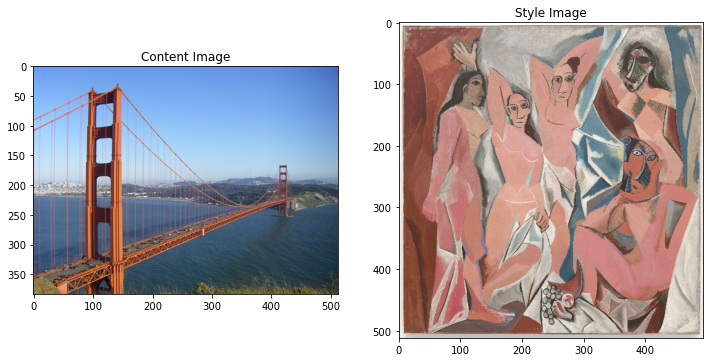

In [15]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### TFハブを使用した高速スタイル転送
#### このチュートリアルでは、画像コンテンツを特定のスタイルに最適化する、元のスタイル転送アルゴリズムを示します。詳細に入る前に、 TensorFlowハブモデルがこれをどのように行うかを見てみましょう。

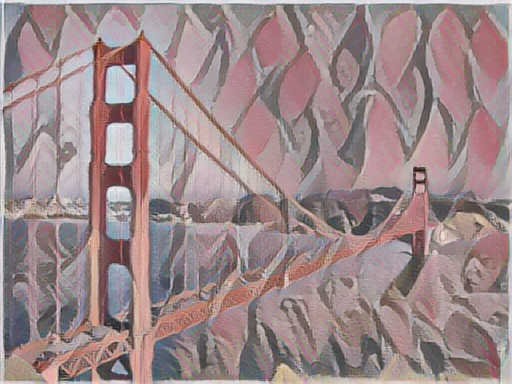

In [16]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### コンテンツとスタイルの表現を定義する
#### モデルの中間レイヤーを使用して、画像のコンテンツとスタイルの表現を取得します。ネットワークの入力レイヤーから始めて、最初のいくつかのレイヤーのアクティブ化は、エッジやテクスチャなどの低レベルの機能を表します。ネットワークをステップスルーすると、最後のいくつかのレイヤーは、より高いレベルの機能（ホイールや目などのオブジェクトパーツ）を表します。この場合、事前にトレーニングされた画像分類ネットワークであるVGG19ネットワークアーキテクチャを使用しています。これらの中間レイヤーは、画像からコンテンツとスタイルの表現を定義するために必要です。入力画像の場合、これらの中間レイヤーで対応するスタイルとコンテンツターゲットの表現を一致させてみてください。

#### VGG19をロードし、イメージでテスト実行して、正しく使用されていることを確認します。

In [17]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [18]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('suspension_bridge', 0.52742875),
 ('pier', 0.2947702),
 ('promontory', 0.119341135),
 ('container_ship', 0.028829921),
 ('fireboat', 0.0077623622)]

#### 次に、分類ヘッドなしでVGG19をロードし、レイヤー名をリストします。

In [19]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### ネットワークから中間​​レイヤーを選択して、画像のスタイルとコンテンツを表します。

In [20]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### スタイルとコンテンツの中間レイヤー

#### では、事前にトレーニングされた画像分類ネットワーク内のこれらの中間出力により、スタイルとコンテンツの表現を定義できるのはなぜですか？


#### 大まかに言えば、ネットワークが画像分類（このネットワークが行うように訓練されている）を実行するためには、画像を理解する必要があります。これには、生の画像を入力ピクセルとして取得し、生の画像のピクセルを画像内に存在する特徴の複雑な理解に変換する内部表現を構築する必要があります。


#### これは、畳み込みニューラルネットワークがうまく一般化できる理由でもあります。それらは、バックグラウンドノイズやその他の迷惑にとらわれないクラス（猫と犬など）内の不変性と定義機能をキャプチャできます。したがって、生の画像がモデルに入力される場所と出力分類ラベルの間のどこかで、モデルは複雑な特徴抽出器として機能します。モデルの中間レイヤーにアクセスすることで、入力画像のコンテンツとスタイルを説明できます。


### モデルを構築する

#### tf.keras.applicationsのネットワークは、 tf.keras.applications機能APIを使用して中間層の値を簡単に抽出できるように設計されています。


#### 機能APIを使用してモデルを定義するには、入力と出力を指定します。


#### model = Model(inputs, outputs)


#### 次の関数は、中間層の出力のリストを返すVGG19モデルを作成します。

In [21]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

#### そして、モデルを作成するには

In [22]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 494, 64)
  min:  0.0
  max:  852.8865
  mean:  31.549944

block2_conv1
  shape:  (1, 256, 247, 128)
  min:  0.0
  max:  4124.8755
  mean:  168.15431

block3_conv1
  shape:  (1, 128, 123, 256)
  min:  0.0
  max:  9875.579
  mean:  163.6575

block4_conv1
  shape:  (1, 64, 61, 512)
  min:  0.0
  max:  18986.818
  mean:  678.319

block5_conv1
  shape:  (1, 32, 30, 512)
  min:  0.0
  max:  2663.7517
  mean:  53.119263



### スタイルを計算する
#### 画像の内容は、中間特徴マップの値で表されます。

#### 結局のところ、画像のスタイルは、さまざまな特徴マップ間の平均と相関関係によって説明できます。特徴ベクトルの外積を各位置でそれ自体と取り、その外積をすべての場所で平均することにより、この情報を含むグラム行列を計算します。このグラム行列は、特定のレイヤーについて次のように計算できます。

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

#### これは、 tf.linalg.einsum関数を使用して簡潔に実装できます。

In [23]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### スタイルとコンテンツを抽出する
#### スタイルとコンテンツテンソルを返すモデルを作成します。

In [24]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

#### 画像で呼び出されると、このモデルはstyle_layersグラム行列（スタイル）とcontent_layersコンテンツを返します。

In [25]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.030003963
    max:  30379.21
    mean:  700.9685

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  114418.164
    mean:  13998.48

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.7272493
    max:  343280.03
    mean:  16707.168

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4244239.0
    mean:  217409.4

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  84026.51
    mean:  1813.9166

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1080.0221
    mean:  14.361252


### 最急降下法を実行します
#### このスタイルとコンテンツの抽出機能を使用して、スタイル転送アルゴリズムを実装できるようになりました。これを行うには、各ターゲットに対する画像の出力の平均二乗誤差を計算し、これらの損失の加重和を取ります。

#### スタイルとコンテンツのターゲット値を設定します。

In [26]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#### 最適化する画像を含むtf.Variableを定義します。これをすばやく行うには、コンテンツイメージで初期化します（ tf.Variableはコンテンツイメージと同じ形状である必要があります）。

In [27]:
image = tf.Variable(content_image)

#### これはフロート画像なので、ピクセル値を0から1の間に保つ関数を定義します。

In [28]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### オプティマイザを作成します。この論文ではLBFGSを推奨していますが、 Adamも問題なく機能します。

In [29]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#### これを最適化するには、2つの損失の加重組み合わせを使用して、合計損失を取得します。

In [30]:
style_weight=1e-2
content_weight=1e4

In [31]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#### tf.GradientTapeを使用して画像を更新します。

In [32]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### 次に、いくつかの手順を実行してテストします。

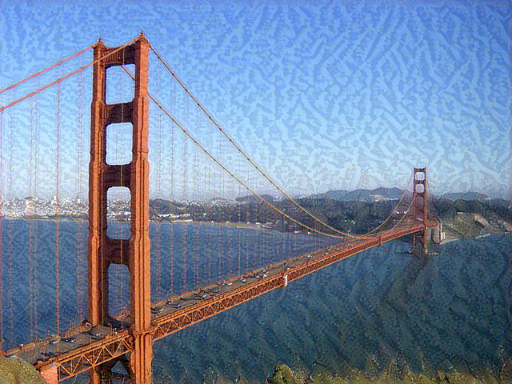

In [33]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

#### 動作しているので、より長い最適化を実行します。




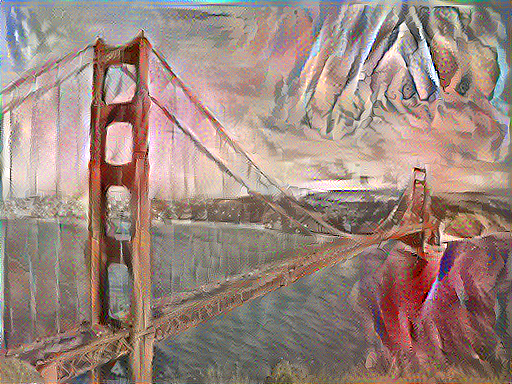

Train step: 1000
Total time: 6172.7


In [34]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### 全変動損失
#### この基本的な実装の欠点の1つは、高周波のアーティファクトが多数生成されることです。画像の高周波成分に明示的な正則化項を使用して、これらを減らします。スタイル転送では、これはしばしば全変動損失と呼ばれます。


In [35]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

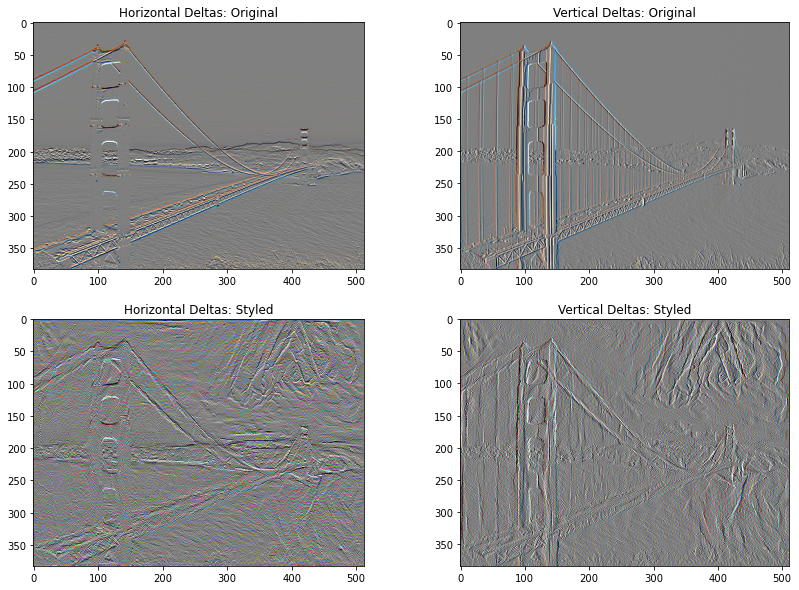

In [36]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

#### これは、高周波成分がどのように増加したかを示しています。

#### また、この高周波成分は基本的にエッジ検出器です。 Sobelエッジ検出器から同様の出力を取得できます。次に例を示します。

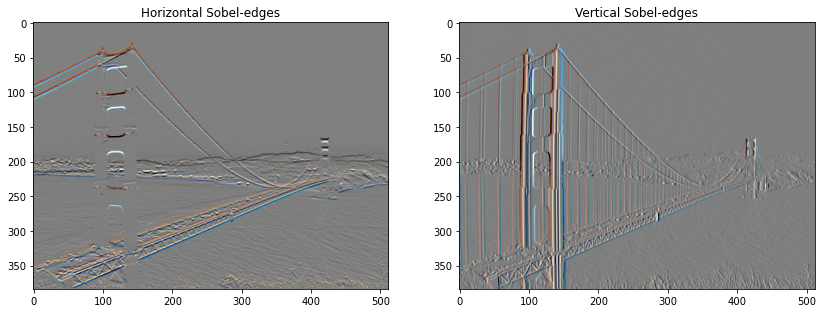

In [37]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

#### これに関連する正則化損失は、値の2乗の合計です。

In [38]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [39]:
total_variation_loss(image).numpy()

103432.31

#### それはそれが何をするかを示しました。ただし、自分で実装する必要はありません。TensorFlowには標準の実装が含まれています。

In [40]:
tf.image.total_variation(image).numpy()

array([103432.31], dtype=float32)

### 最適化を再実行します
#### total_variation_loss重みを選択しtotal_variation_loss

In [41]:
total_variation_weight=30

#### 次に、 train_step関数にtrain_stepます。

In [42]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### 最適化変数を再初期化します。

In [43]:
image = tf.Variable(content_image)

#### そして、最適化を実行します。

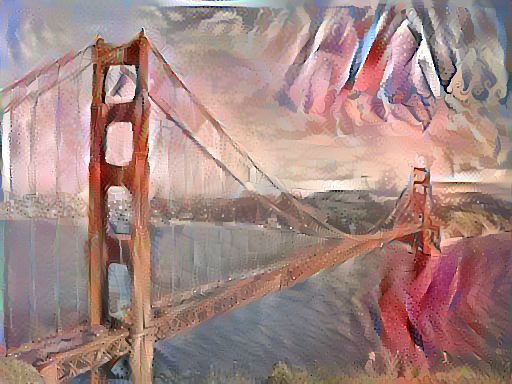

Train step: 1000
Total time: 5122.5


In [44]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#### 最後に、結果を保存します。

In [45]:
file_name = 'stylized-image2.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)